In [63]:
import os

experiment_name = "example_2"
if not os.path.exists("./results/" + experiment_name + "/"):
    os.makedirs("./results/" + experiment_name + "/")
    
import pandas as pd
data = pd.read_csv("Desktop/chapter_19/total_freesurfer_final_data_matched_site_mac_noise7.csv")


data.loc[0:5]


,ID,label,Gender,Age,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,...,rh_rostralanteriorcingulate_thickness,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness
0,c001,0,0,35,4226.907844,414.407845,12242.90784,43410.50784,7020.107844,4133.407844,...,2.440844,2.522844,2.656844,2.123844,2.638844,2.420844,2.489844,2.235844,2.300844,2.645844
1,c002,0,1,37,4954.912699,414.812699,16519.51270,38808.31270,7013.312699,3882.912699,...,2.507699,2.470699,2.645699,2.132699,2.848699,2.425699,2.883699,2.622699,2.322699,2.673699
2,c003,0,1,32,4470.611989,370.111989,10193.51199,38637.51199,5802.911989,2941.711989,...,2.545989,2.589989,2.885989,2.317989,2.326989,2.454989,2.482989,2.232989,2.267989,2.795989
3,c004,0,1,36,7553.310654,521.010654,12716.01065,41933.31065,5998.310654,2869.110654,...,2.323654,2.411654,2.770654,2.149654,2.458654,2.307654,3.284654,1.956654,2.297654,2.731654
4,c005,0,0,22,8785.212771,396.912771,12077.41277,41818.91277,5839.812771,3614.812771,...,3.211771,2.467771,2.772771,2.051771,2.588771,2.325771,3.266771,3.162771,2.081771,2.607771
5,c006,0,1,34,5083.706643,172.106643,11927.50664,38730.80664,5693.506643,3422.606643,...,2.562643,2.603643,2.948643,2.177643,2.489643,2.362643,2.314643,3.512643,2.591643,2.606643


In [64]:
shape = data.shape
print("Number of features=", shape[1])
print("Number of participants =", shape[0])

Number of features= 173
Number of participants = 740


In [65]:
y = data["label"]
X = data.iloc[:,4:]

#Sample size and number of features
print("Total N:", len(y))
print("N features:", len(X.columns))
print("N healthy participants:", len(y[y==0]))
print("N healthy participants:", len(y[y==1]))

Total N: 740
N features: 169
N healthy participants: 368
N healthy participants: 372


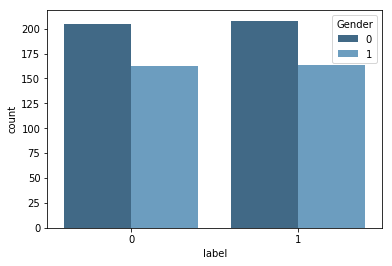

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

#Distribution of HC and AD per gender
gender = data["Gender"]
age = data["Age"]

#Plot gender and labels
ax = sns.countplot(x=y, hue=gender, palette="Blues_d")
plt.show()

In [67]:
mean = (data.groupby("label")["Age"].mean()).round(1)
sd = (data.groupby("label")["Age"].std()).round(1)
print("Mean age for HC:", mean[0],"±",sd[0])
print("Mean age for AD:", mean[1],"±",sd[1])

Mean age for HC: 27.8 ± 7.6
Mean age for AD: 27.6 ± 7.9


In [51]:
def detect_nan(dataset):
    
    nan_total = dataset.isnull().sum().sum()
    
    if nan_total > 0:
        for column in dataset:          
            #Find Ids with nan - THIS IS PROBABLY OVERLY COMPLICATED (all I want here is to get the Ids of where the nans are so I can print them later on)
            nan = dataset[column].isnull()
            dataset["nan"] = nan 
            ids = []
            for i in dataset["nan"]:
                if i == True:
                    id_nan = dataset.loc[dataset["nan"] == True, 'ID']
                    ids.append(id_nan)        
            
            
            #Calculate total number of nan for each feature and Id
            nan_sum = nan.sum()          
            if nan_sum > 0:
                print("Found", nan_sum, "missing value(s) for", column, "for Id(s):", *ids[0])
                
        #dataset = dataset.drop(columns=["nan"])
    
    else:
        print("There are no missing data in this dataset!")
    
detect_nan(data)

There are no missing data in this dataset!


In [52]:
import numpy as np

X = np.asarray(X.values, dtype='float32')
y = np.asarray(y.values, dtype='float32')

In [53]:


from sklearn.model_selection import StratifiedKFold

n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

cv_test_bac = np.zeros((n_folds,))
cv_test_sens = np.zeros((n_folds,))
cv_test_spec = np.zeros((n_folds,))
cv_error_rate = np.zeros((n_folds,))

coefficients = []

for i_fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("")
    print("k-fold: ", i_fold + 1)
    print("N training set:", len(y_train))
    print("N test set:", len(y_test))
    
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler().fit(X_train)
    X_train_n = scaler.transform(X_train)
    X_test_n = scaler.transform(X_test)

    
    from sklearn.metrics import make_scorer
    from sklearn.metrics import confusion_matrix

    def balanced_accuracy_score(actual, prediction):
        cm = confusion_matrix(actual, prediction)
        bac = np.sum(np.true_divide(np.diagonal(cm), np.sum(cm, axis=1))) / cm.shape[1]
        return bac
    grid_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)
    
    from sklearn.svm import LinearSVC

    clf = LinearSVC()
    
    from sklearn.model_selection import GridSearchCV

    #Hyperparameter seach space
    param_grid = [
        {'C': [2e-6, 2e-5, 2e-4, 2e-3, 2e-2, 2e-1, 2e0, 2e1, 2e2, 2e3]},
    ]
    
    #Gridsearch
    internal_cv = StratifiedKFold(n_splits=10)
    grid_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=internal_cv, scoring=grid_scorer, verbose=1)
    
    grid_result = grid_clf.fit(X_train_n, y_train)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    clf2 = LinearSVC(C=grid_result.best_params_["C"])
    clf2.fit(X_train_n, y_train)
    y_predicted = clf2.predict(X_test_n)
    
    print("Confusion matrix")
    cm = confusion_matrix(y_test, y_predicted)
    print(cm)
    print("")

    test_bac = np.sum(np.true_divide(np.diagonal(cm), np.sum(cm, axis=1))) / cm.shape[1]
    test_sens = np.true_divide(cm[1, 1], np.sum(cm[1, :]))
    test_spec = np.true_divide(cm[0, 0], np.sum(cm[0, :]))
    error_rate = np.true_divide(cm[0, 1] + cm[1, 0], np.sum(np.sum(cm)))

    print("Balanced acc: %.4f " % (test_bac))
    print("Sensitivity: %.4f " % (test_sens))
    print("Specificity: %.4f " % (test_spec))
    print("Error Rate: %.4f " % (error_rate))

    cv_test_bac[i_fold - 1] = test_bac
    cv_test_sens[i_fold - 1] = test_sens
    cv_test_spec[i_fold - 1] = test_spec
    cv_error_rate[i_fold - 1] = error_rate
    
    coefficients_fold = clf2.coef_
    coefficients.append(coefficients_fold)
    
    import csv

    if i_fold == 0:
        file_predictions = open("./results/" + experiment_name + "/error_analysis.csv", 'w')
        wr = csv.writer(file_predictions)
        wr.writerow(['INDEX', 'TRUE LABEL', 'PREDICTED'])
    else:
        file_predictions = open("./results/" + experiment_name + "/error_analysis.csv", 'a')
        wr = csv.writer(file_predictions)
    for j, fname in enumerate(test_index):
        wr.writerow([(str(fname)), str(y_test[j]), str(y_predicted[j])])
    wr.writerow(['-', '-', '-'])
    file_predictions.close()
    
    
    import pickle
    f = open("./results/"+experiment_name+"/clf_"+str(i_fold)+".pkl", 'wb')
    pickle.dump(clf, f)
    f.close()
    
print("Cross-validation Balanced acc: %.4f +- %.4f" % (cv_test_bac.mean(), cv_test_bac.std()))
print("Cross-validation Sensitivity: %.4f +- %.4f" % (cv_test_sens.mean(), cv_test_sens.std()))
print("Cross-validation Specificity: %.4f +- %.4f" % (cv_test_spec.mean(), cv_test_spec.std()))
print("Cross-validation Error Rate: %.4f +- %.4f" % (cv_error_rate.mean(), cv_error_rate.std()))


f = open("./results/" + experiment_name + "/final_BAC.pkl", 'wb')
pickle.dump(cv_test_bac, f)
f.close()


k-fold:  1
N training set: 665
N test set: 75
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/bas

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.651478 using {'C': 0.02}
0.586956 (0.087405) with: {'C': 2e-06}
0.591580 (0.082577) with: {'C': 2e-05}
0.594652 (0.076490) with: {'C': 0.0002}
0.635070 (0.089754) with: {'C': 0.002}
0.651478 (0.104129) with: {'C': 0.02}
0.639336 (0.089715) with: {'C': 0.2}
0.627350 (0.084864) with: {'C': 2.0}
0.631885 (0.074097) with: {'C': 20.0}
0.640839 (0.085528) with: {'C': 200.0}
0.639291 (0.086961) with: {'C': 2000.0}
Confusion matrix
[[30  7]
 [ 9 29]]

Balanced acc: 0.7870 
Sensitivity: 0.7632 
Specificity: 0.8108 
Error Rate: 0.2133 

k-fold:  2
N training set: 665
N test set: 75
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.680214 using {'C': 0.02}
0.592997 (0.103384) with: {'C': 2e-06}
0.594657 (0.086310) with: {'C': 2e-05}
0.611400 (0.071588) with: {'C': 0.0002}
0.617276 (0.068312) with: {'C': 0.002}
0.680214 (0.060854) with: {'C': 0.02}
0.663581 (0.066414) with: {'C': 0.2}
0.675455 (0.064720) with: {'C': 2.0}
0.655951 (0.070155) with: {'C': 20.0}
0.667847 (0.063879) with: {'C': 200.0}
0.666478 (0.054204) with: {'C': 2000.0}
Confusion matrix
[[26 11]
 [ 8 30]]

Balanced acc: 0.7461 
Sensitivity: 0.7895 
Specificity: 0.7027 
Error Rate: 0.2533 

k-fold:  3
N training set: 666
N test set: 74
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.651749 using {'C': 0.02}
0.576897 (0.085870) with: {'C': 2e-06}
0.596530 (0.071363) with: {'C': 2e-05}
0.599665 (0.081099) with: {'C': 0.0002}
0.617390 (0.086182) with: {'C': 0.002}
0.651749 (0.085180) with: {'C': 0.02}
0.638190 (0.082442) with: {'C': 0.2}
0.632117 (0.078669) with: {'C': 2.0}
0.609503 (0.097002) with: {'C': 20.0}
0.618603 (0.088433) with: {'C': 200.0}
0.635321 (0.076523) with: {'C': 2000.0}
Confusion matrix
[[24 13]
 [ 8 29]]

Balanced acc: 0.7162 
Sensitivity: 0.7838 
Specificity: 0.6486 
Error Rate: 0.2838 

k-fold:  4
N training set: 666
N test set: 74
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.675799 using {'C': 0.02}
0.584407 (0.098790) with: {'C': 2e-06}
0.593506 (0.089738) with: {'C': 2e-05}
0.607196 (0.082230) with: {'C': 0.0002}
0.652131 (0.075146) with: {'C': 0.002}
0.675799 (0.069312) with: {'C': 0.02}
0.660491 (0.071094) with: {'C': 0.2}
0.654507 (0.071049) with: {'C': 2.0}
0.651484 (0.075779) with: {'C': 20.0}
0.636401 (0.053732) with: {'C': 200.0}
0.669324 (0.063934) with: {'C': 2000.0}
Confusion matrix
[[26 11]
 [ 9 28]]

Balanced acc: 0.7297 
Sensitivity: 0.7568 
Specificity: 0.7027 
Error Rate: 0.2703 

k-fold:  5
N training set: 666
N test set: 74
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.674388 using {'C': 0.02}
0.587455 (0.089644) with: {'C': 2e-06}
0.595007 (0.080263) with: {'C': 2e-05}
0.616116 (0.094907) with: {'C': 0.0002}
0.653409 (0.094650) with: {'C': 0.002}
0.674388 (0.094251) with: {'C': 0.02}
0.668182 (0.086787) with: {'C': 0.2}
0.654532 (0.075626) with: {'C': 2.0}
0.642496 (0.115994) with: {'C': 20.0}
0.642475 (0.075024) with: {'C': 200.0}
0.625869 (0.081582) with: {'C': 2000.0}
Confusion matrix
[[28  9]
 [ 9 28]]

Balanced acc: 0.7568 
Sensitivity: 0.7568 
Specificity: 0.7568 
Error Rate: 0.2432 

k-fold:  6
N training set: 666
N test set: 74
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.662172 using {'C': 0.02}
0.584449 (0.114161) with: {'C': 2e-06}
0.585996 (0.097306) with: {'C': 2e-05}
0.611589 (0.080336) with: {'C': 0.0002}
0.648815 (0.071762) with: {'C': 0.002}
0.662172 (0.072241) with: {'C': 0.02}
0.639648 (0.065129) with: {'C': 0.2}
0.647089 (0.063609) with: {'C': 2.0}
0.627545 (0.073329) with: {'C': 20.0}
0.659146 (0.083325) with: {'C': 200.0}
0.645454 (0.043546) with: {'C': 2000.0}
Confusion matrix
[[26 11]
 [10 27]]

Balanced acc: 0.7162 
Sensitivity: 0.7297 
Specificity: 0.7027 
Error Rate: 0.2838 

k-fold:  7
N training set: 666
N test set: 74
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.659280 using {'C': 2.0}
0.573804 (0.072923) with: {'C': 2e-06}
0.578399 (0.070642) with: {'C': 2e-05}
0.582856 (0.077278) with: {'C': 0.0002}
0.603853 (0.085278) with: {'C': 0.002}
0.641373 (0.067910) with: {'C': 0.02}
0.654799 (0.057041) with: {'C': 0.2}
0.659280 (0.064164) with: {'C': 2.0}
0.635344 (0.081488) with: {'C': 20.0}
0.651996 (0.082318) with: {'C': 200.0}
0.639849 (0.068687) with: {'C': 2000.0}
Confusion matrix
[[31  6]
 [ 8 29]]

Balanced acc: 0.8108 
Sensitivity: 0.7838 
Specificity: 0.8378 
Error Rate: 0.1892 

k-fold:  8
N training set: 666
N test set: 74
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.690926 using {'C': 0.02}
0.585839 (0.087309) with: {'C': 2e-06}
0.595005 (0.076201) with: {'C': 2e-05}
0.604078 (0.098603) with: {'C': 0.0002}
0.640161 (0.091835) with: {'C': 0.002}
0.690926 (0.082424) with: {'C': 0.02}
0.674208 (0.080760) with: {'C': 0.2}
0.674186 (0.080617) with: {'C': 2.0}
0.653004 (0.112450) with: {'C': 20.0}
0.627365 (0.072569) with: {'C': 200.0}
0.665088 (0.072654) with: {'C': 2000.0}
Confusion matrix
[[25 12]
 [ 9 28]]

Balanced acc: 0.7162 
Sensitivity: 0.7568 
Specificity: 0.6757 
Error Rate: 0.2838 

k-fold:  9
N training set: 667
N test set: 73
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.654989 using {'C': 20.0}
0.572777 (0.089022) with: {'C': 2e-06}
0.575774 (0.070237) with: {'C': 2e-05}
0.584788 (0.084461) with: {'C': 0.0002}
0.623657 (0.081742) with: {'C': 0.002}
0.644672 (0.075077) with: {'C': 0.02}
0.650714 (0.074350) with: {'C': 0.2}
0.638518 (0.089548) with: {'C': 2.0}
0.654989 (0.068039) with: {'C': 20.0}
0.646083 (0.068316) with: {'C': 200.0}
0.633997 (0.064307) with: {'C': 2000.0}
Confusion matrix
[[24 12]
 [14 23]]

Balanced acc: 0.6441 
Sensitivity: 0.6216 
Specificity: 0.6667 
Error Rate: 0.3562 

k-fold:  10
N training set: 667
N test set: 73
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Best: 0.661029 using {'C': 0.02}
0.572844 (0.094714) with: {'C': 2e-06}
0.587836 (0.086161) with: {'C': 2e-05}
0.595239 (0.086015) with: {'C': 0.0002}
0.623657 (0.078905) with: {'C': 0.002}
0.661029 (0.098758) with: {'C': 0.02}
0.653445 (0.074425) with: {'C': 0.2}
0.650490 (0.080864) with: {'C': 2.0}
0.641471 (0.062169) with: {'C': 20.0}
0.644577 (0.119703) with: {'C': 200.0}
0.620480 (0.111737) with: {'C': 2000.0}
Confusion matrix
[[32  4]
 [10 27]]

Balanced acc: 0.8093 
Sensitivity: 0.7297 
Specificity: 0.8889 
Error Rate: 0.1918 
Cross-validation Balanced acc: 0.7432 +- 0.0482
Cross-validation Sensitivity: 0.7472 +- 0.0462
Cross-validation Specificity: 0.7393 +- 0.0769
Cross-validation Error Rate: 0.2569 +- 0.0481


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.3s finished
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


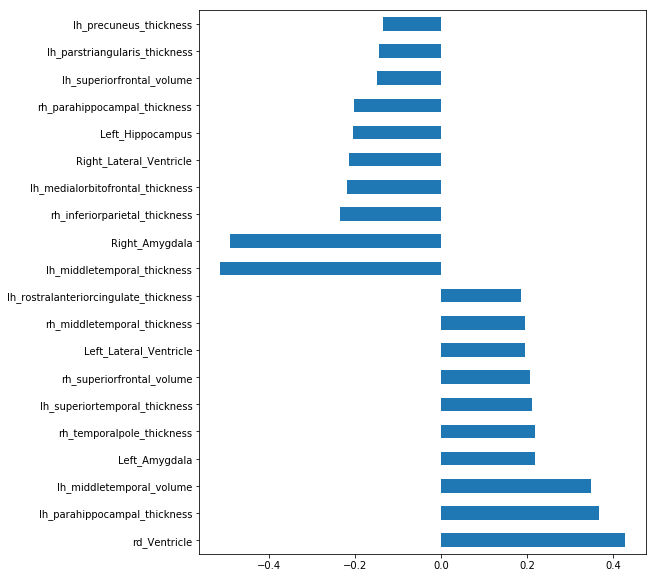

In [54]:
def plot_coefs(coeffs): #this code works but it is not very elegant.
    coeffs = np.mean((np.asarray(coeffs)), axis=0)

    feature_names = data.iloc[:,4:].columns #get feature names from original data
    coeffs = pd.DataFrame(data=coeffs, columns=feature_names)
    coeffs = coeffs.transpose()

    #get top positive and negative weights
    largest_coefs = coeffs.nlargest(n=10, columns=0) 
    smallest_coefs = coeffs.nsmallest(n=10, columns=0)
    
    ax = pd.concat([largest_coefs,smallest_coefs], axis=0, sort=True) #concat for plotting
    ax.plot(kind='barh', figsize=(8,10), legend=False) #plot weights
    
plot_coefs(coefficients)

In [55]:
models = []
for i in range(n_folds):
    print("Loading models ", i)
    f = open("./results/"+experiment_name+"/clf_"+str(i)+".pkl", 'rb')
    models.append(pickle.load(f))
    f.close()

f = open("./results/"+experiment_name+"/final_BAC.pkl", 'rb')
best_BAC = pickle.load(f)
f.close()

Loading models  0
Loading models  1
Loading models  2
Loading models  3
Loading models  4
Loading models  5
Loading models  6
Loading models  7
Loading models  8
Loading models  9


In [62]:
from sklearn.base import clone

n_permutation = 10
permutation_test_bac = np.zeros((n_permutation,))

print("Starting permutation with ", n_permutation, " iterations")
for p in range(n_permutation):

    np.random.seed(seed + p)
    permuted_labels = np.random.permutation(y)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

    cv_test_bac = np.zeros((n_folds,))

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # ---------------------------------------------------------------------------------------------
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = permuted_labels[train_index], permuted_labels[test_index]

        # ------------------------------- Normalization ------------------------------------------------
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        clf = clone(models[i])

        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)

        # -------------------------- Performance metrics -------------------------------------------
        cm = confusion_matrix(y_test, y_predicted)

        test_bac = np.sum(np.true_divide(np.diagonal(cm), np.sum(cm, axis=1))) / cm.shape[1]
        cv_test_bac[i - 1] = test_bac

    permutation_test_bac[p] = cv_test_bac.mean()
    print("Permutation: ", p, " BAC: ", cv_test_bac.mean())

print("")
print("BEST BAC", best_BAC.mean())
pvalue = (np.sum((permutation_test_bac>best_BAC.mean()).astype('int'))+1.)/(n_permutation+1.)
print("P-VALUE", pvalue)

f = open("./results/"+experiment_name+"/p-value.pkl", 'wb')
pickle.dump(pvalue, f)
f.close()

Starting permutation with  10  iterations


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  0  BAC:  0.47655384789472544


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  1  BAC:  0.5272525619180728


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  2  BAC:  0.4714770310906006


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  3  BAC:  0.5057836634213069


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  4  BAC:  0.4946792877541412


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  5  BAC:  0.5550643836266429


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  6  BAC:  0.5001424066529656


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  7  BAC:  0.5288656968109605


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  8  BAC:  0.459743078009733


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o

Permutation:  9  BAC:  0.4884060689743617

BEST BAC 0.743247194562984
P-VALUE 0.09090909090909091


/Users/sandra/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
